Aperçu des 5 premières lignes :
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373

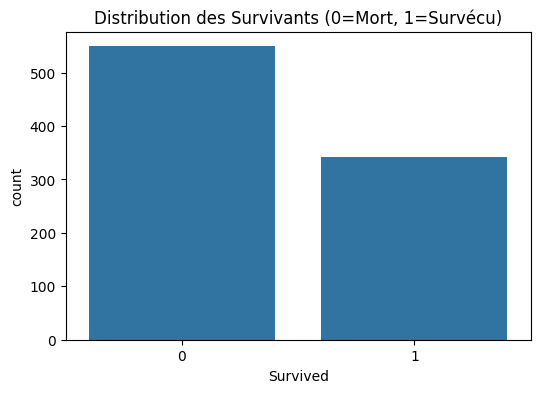

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chargement du jeu de données d'entraînement
df = pd.read_csv('train.csv')

# Aperçu du DataFrame
print("Aperçu des 5 premières lignes :")
print(df.head())

# Information sur les types de données et les valeurs manquantes
print("\nStatut des colonnes et valeurs manquantes :")
df.info()

# Visualisation de la variable cible
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.title('Distribution des Survivants (0=Mort, 1=Survécu)')
plt.show()

# Note parch : nombre parent-enfant; fare: prix du ticket; SibSp  : nombre femme/cousin/proche; Pclass : Passenger class 1 à 3

In [ ]:
#Tâche : Classification binaire (Survived: 0 ou 1).
#Valeurs Manquantes Importantes :
#Age : Environ 20 % de valeurs manquantes (gestion par imputation).
#Cabin : Plus de 77 % de valeurs manquantes (gestion par suppression ou simplification).
#Embarked : Seulement 2 valeurs manquantes (gestion facile par mode).
#Variables Catégorielles à Encoder : Sex, Embarked, Pclass (ordinal), Name (pour en extraire le titre).

In [ ]:
#2.  Ingénierie des Caractéristiques et Nettoyage

In [12]:
# --- 1. Gestion des Valeurs Manquantes ---

# Imputation de 'Embarked' par le mode (valeur la plus fréquente)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Imputation de 'Age' par la moyenne conditionnelle (par Pclass)
# L'âge dépend fortement de la classe sociale (Pclass)
df['Age'] = df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))

# --- 2. Ingénierie de Caractéristique : Extraction du Titre ---

# Extraction du titre de la colonne 'Name'
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+).', expand=False)

# Simplification et regroupement des titres rares
rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# --- 3. Suppression et Encodage ---

# Suppression des colonnes non utilisées
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Encodage One-Hot des variables catégorielles
# drop_first=True est utilisé pour éviter la multicolinéarité
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# Affichage des colonnes pour vérifier le résultat de l'encodage
print("\nColonnes après One-Hot Encoding:")
print(df.columns)
print(df.head)


Colonnes après One-Hot Encoding:
Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Carlo', 'Title_Cruyssen',
       'Title_Gordon', 'Title_Impe', 'Title_Master', 'Title_Melkebeke',
       'Title_Messemaeker', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Mulder', 'Title_Pelsmaeker', 'Title_Planke', 'Title_Rare',
       'Title_Shawah', 'Title_Steen', 'Title_Velde', 'Title_Walle',
       'Title_der', 'Title_the', 'Title_y'],
      dtype='object')
<bound method NDFrame.head of      PassengerId  Survived  Pclass       Age  SibSp  Parch     Fare  Sex_male  \
0              1         0       3  22.00000      1      0   7.2500      True   
1              2         1       1  38.00000      1      0  71.2833     False   
2              3         1       3  26.00000      0      0   7.9250     False   
3              4         1       1  35.00000      1      0  53.1000     False   
4              5         0 

In [ ]:
#3.  Modélisation et Comparaison

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- 1. Préparation des jeux de données ---

# X exclut la cible et l'ID Passager
X = df.drop(['Survived', 'PassengerId'], axis=1)
y = df['Survived']

# Séparation 80/20 pour l'entraînement et le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalisation des caractéristiques pour les modèles linéaires (Age, Fare, SibSp, Parch)
numerical_cols = ['Age', 'Fare', 'SibSp', 'Parch']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 2. Modèle Baseline : Régression Logistique ---
log_model = LogisticRegression(random_state=42, solver='liblinear')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)


# --- 3. Modèle Avancé : Random Forest Classifier ---
# Note : Random Forest n'est pas sensible au scaling/normalisation, mais on peut utiliser X_train scalé ici.
forest_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

In [ ]:
#4.  Évaluation Critique et Interprétation

Accuracy (Régression Logistique) : 0.8212
Accuracy (Random Forest) : 0.7989

--- Matrice de Confusion (Random Forest) ---
[[Vrais Négatifs (Mort), Faux Positifs (Erreur type I)]
[Faux Négatifs (Erreur type II), Vrais Positifs (Survécu)]]
[[91 14]
 [22 52]]

--- Rapport de Classification (Random Forest) ---
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Score ROC AUC (Random Forest) : 0.8895



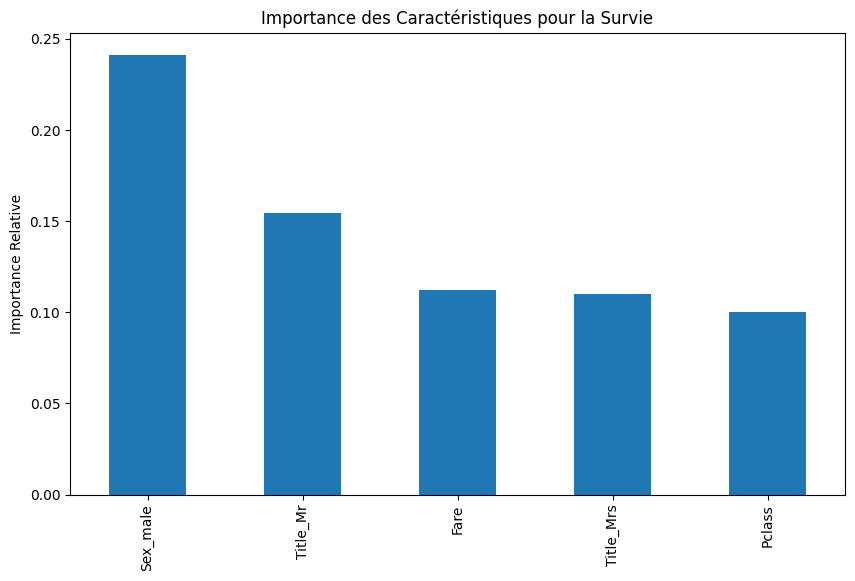

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

# --- 1. Évaluation du Random Forest (généralement le meilleur) ---

# Accuracy
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy (Régression Logistique) : {accuracy_log:.4f}")
print(f"Accuracy (Random Forest) : {accuracy_forest:.4f}\n")

# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred_forest)
print("--- Matrice de Confusion (Random Forest) ---")
print(f"[[Vrais Négatifs (Mort), Faux Positifs (Erreur type I)]")
print(f"[Faux Négatifs (Erreur type II), Vrais Positifs (Survécu)]]")
print(conf_matrix)

# Rapport de Classification (F1 Score)
print("\n--- Rapport de Classification (Random Forest) ---")
print(classification_report(y_test, y_pred_forest))

# Score AUC (Area Under the Curve)
y_proba_forest = forest_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_forest)
print(f"Score ROC AUC (Random Forest) : {roc_auc:.4f}\n")

# --- 2. Interprétation : Importance des Caractéristiques ---

feature_importances = pd.Series(forest_model.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).head(5).plot(kind='bar')
plt.title("Importance des Caractéristiques pour la Survie")
plt.ylabel("Importance Relative")
plt.show()

In [ ]:
# Matrice de Confusion : Analyser le nombre de Faux Négatifs (FN, passagers qui ont survécu mais que le modèle a prédit morts). 
#Ces erreurs sont souvent considérées comme plus coûteuses que les Faux Positifs (FP).

#F_1 Score : est plus pertinent que l'Accuracy sur ce jeu de données (déséquilibré).
#AUC : Une valeur d'AUC proche de 1 (0.8895 ici) indique une excellente capacité du modèle à distinguer les classes.

#Importance des Caractéristiques : Confirme que le sexe (Sex_male) et le titre (Title_Mr., Title_Miss., etc.) sont les prédicteurs les plus importants de la survie, suivis par la classe de passager (Pclass) et le tarif (Fare).
# Conclusion : les riches ont mieux survécus.

In [15]:
import joblib
import os

# Créer le dossier de sauvegarde si non existant
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Sauvegarder le meilleur modèle (ici, le Random Forest)
joblib.dump(forest_model, 'saved_models/final_titanic_classifier.pkl')

print("Modèle Random Forest sauvegardé dans 'saved_models/final_titanic_classifier.pkl'.")

Modèle Random Forest sauvegardé dans 'saved_models/final_titanic_classifier.pkl'.
